# Packages

In [1]:
import pandas as pd
import joblib
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.stats import beta

# Functions

## Results analysis functions

## over_x
*This function returns the company name, ticker, predicted value, and actual value for datapoints predicted to be > x.*

In [2]:
def over_x(x, y_pred, y_actl, data, original_idx):
    over100_pred = y_pred[y_pred > x]
    over100_idx = list(np.where(y_pred>x)[0])
    data_idx = []
    for j in over100_idx: data_idx.append(original_idx[j])
    over100_actl = y_actl[over100_idx]
    tickers = data['Ticker'][data_idx].values
    companies = data['CompanyName'][data_idx].values
    date = data['MarketCapDate'][data_idx].values
    return [companies, tickers, date, over100_pred, over100_actl]

## Data loading & processing functions

## compute_ratio_data
*This function computes the financial ratios from the given dataset to be used as the training dataset by the downstream machine learning model.*

In [3]:
def compute_ratio_data(data):
    ratio_data = pd.DataFrame()
    ratio_data['P/E'] = data['MarketCap'] / data['NetIncome']
    ratio_data['P/B'] = data['MarketCap'] / data['TotalEquity']
    ratio_data['P/S'] = data['MarketCap'] / data['Revenue']
    ratio_data['P/OpIn'] = data['MarketCap'] / data['OpIncome']
    ratio_data['P/FCF'] = data['MarketCap'] / (data['OpCashFlow'] - data['CapEx'])
    ratio_data['FCF/OpCF'] = (data['OpCashFlow'] - data['CapEx']) / data['OpCashFlow']
    ratio_data['EV/EBIT'] = data['EV'] / data['EBIT']
    ratio_data['CurrentRatio'] = data['TotalCurrentAssets'] / data['TotalCurrentLiabilities']
    ratio_data['ROA'] = data['NetIncome'] / data['TotalAssets']
    ratio_data['ROCE'] = data['EBIT'] / (data['TotalAssets'] - data['TotalCurrentLiabilities'])
    ratio_data['ROE'] = data['NetIncome'] / data['TotalEquity']
    ratio_data['NetProfitMargin'] = data['NetIncome'] / data['Revenue']
    ratio_data['DebtRatio'] = data['TotalAssets'] / data['TotalLiabilities']
    ratio_data['CashRatio'] = data['Cash'] / data['TotalCurrentLiabilities']
    return ratio_data

## clean_dataset
    *This function cleans up the "bad" datapoints after the **compute_ratio_data** operation is performed on the dataset.*

In [4]:
def clean_dataset(df_x, df_y):
    assert isinstance(df_x, pd.DataFrame), "df needs to be a pd.DataFrame"
    assert isinstance(df_y, pd.DataFrame), "df needs to be a pd.DataFrame"
    indices_to_keep = ~(df_x.isin([np.nan, np.inf, -np.inf]).any(1))
    df_x = df_x[indices_to_keep].astype(np.float64)
    df_y = df_y[indices_to_keep]
    out_idx = list(df_x.index)
    df_x.reset_index()
    df_y.reset_index()
    return df_x, df_y, out_idx

## load_testing_data
*This function loads and prepares the most recent year's data to use as the testing data for the fully trained RFR model.*

In [5]:
def load_testing_data():
    funda_data = pd.read_csv('Annual_FinStatement_Data.csv')
    years = funda_data['Year'].unique()
    x_data = funda_data[funda_data['Year'] == max(years)]
    x_data = x_data.reset_index(drop=True)
    descriptive_x_data = deepcopy(x_data)
    input_features = funda_data.columns
    training_features = list(input_features[4:])
    training_features.remove('MarketCapDate')
    x_data = x_data[training_features]
    x_data = compute_ratio_data(x_data)
    x_data, _, clean_idx = clean_dataset(x_data, x_data)
    x_data = x_data.reset_index(drop=True)
    descriptive_x_data = descriptive_x_data.iloc[clean_idx, :].reset_index(drop=True)
    return x_data, descriptive_x_data

## min_max_transform
*This function linearly transforms each feature of the inputted data (in DataFrame format) between a & b (defaults to between 0 and 1).*

In [6]:
def min_max_transform(data, feature_list, a=0, b=1):
    data_trans = data.copy()    
    for feat in feature_list:
        data_trans[feat] = (data_trans[feat] - data_trans[feat].min()) / (data_trans[feat].max() - data_trans[feat].min()) * (b - a) - a
    return data_trans

## T^2 control chart functions

## hotelling_t2
*This function computes the Hotelling T^2 distribution for the given data, with the given confidence level.*

In [7]:
def hotelling_t2(data, alpha, plot_flag=False): # data is a np.array of size n x p; alpha is the confidence interval (float)
    # Make a copy of input data and save its dimensions    
    x = deepcopy(data)
    n = x.shape[0]
    p = x.shape[1]
    # Calculate Upper Control Limit
    b = beta.ppf(alpha,p/2,0.5*(n-p-1)) # b = Beta inverse cumulative distribution function, see https://www.mathworks.com/help/stats/betainv.html
    ucl = b*(n-1)**2/n # ucl equation from Bell's thesis, section 1.2
    # Calcuate covariance matrix - from Bell's thesis, section 1.2
    xbar = np.mean(x,axis=0).reshape((p,1))
    cov_mat = np.zeros((p,p))
    for i in range(n):
        xi = x[i,:].reshape((p,1))
        cov_mat += np.matmul( (xi - xbar), (xi - xbar).T )
    cov_mat *= (1/(n-1))
    invS = np.linalg.inv(cov_mat)
    # Calculate T^2 distribution - from Bell's thesis, section 1.2
    t2 = np.zeros((n,1))
    for i in range(n):
        xi = x[i,:].reshape((p,1))
        t2[i] = np.matmul( np.matmul( (xi - xbar).T, invS ), (xi - xbar) )
    # Plot Control Chart
    if plot_flag:
        plt.figure()
        plt.plot(list(range(n)), t2,'-k')
        plt.plot(list(range(n)), np.ones(n)*ucl, '--r')
    return t2, ucl

## time_series_plot
*This helper function plots the time series T^2 distribution data in the desired format.*

In [8]:
def time_series_plot(t_data, y_data, title, xlabel, ylabel, linestyle, legend=[]):
    n = t_data.shape[1]
    plt.figure()
    for i in range(n):
        plt.plot(t_data[:,i], y_data[:,i],linestyle[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend != []: plt.legend(legend,loc='best')
    plt.grid(True)

# Prediction

## Load newest data for model to predict

In [9]:
x_data_te, descriptive_x_data_te  = load_testing_data()

## Load & predict using N = +5 years model

In [10]:
N = 5
bw = 50
filename = 'model_N'+str(N)+'.sav'
loaded_model = joblib.load(filename)
y_pred = loaded_model.predict(x_data_te)
spoof_y_actl = pd.DataFrame(['-']*len(y_pred)).values.ravel()
over100_te = over_x(bw, y_pred, spoof_y_actl, descriptive_x_data_te, list(descriptive_x_data_te.index))
x100_N5 = []
print('N={} Model:'.format(N))
for k in range(len(over100_te[0])): 
    r_pred = over100_te[3][k]**(1/N) - 1  
    print('\t\tCompany={}, Ticker={}, Date={}, Prediction={:0.0f}, Actual={}, r={:0.0f}%'.format(over100_te[0][k], over100_te[1][k], over100_te[2][k], over100_te[3][k], over100_te[4][k], r_pred*100))
    x100_N5.append([over100_te[0][k], over100_te[1][k], over100_te[2][k], over100_te[3][k], over100_te[4][k], r_pred])

N=5 Model:
		Company=PASSUR AEROSPACE INC, Ticker=PSSR, Date=2021-01-04, Prediction=262, Actual=-, r=205%
		Company=CHINA GREEN AGRICULTURE INC, Ticker=CGA, Date=2020-08-31, Prediction=74, Actual=-, r=136%
		Company=EZCORP INC  -CL A, Ticker=EZPW, Date=2020-11-30, Prediction=71, Actual=-, r=135%


## Load & predict using N = +10 years model

In [11]:
N = 10
bw = 100
filename = 'model_N'+str(N)+'.sav'
loaded_model = joblib.load(filename)
y_pred = loaded_model.predict(x_data_te)
spoof_y_actl = pd.DataFrame(['-']*len(y_pred)).values.ravel()
over100_te = over_x(bw, y_pred, spoof_y_actl, descriptive_x_data_te, list(descriptive_x_data_te.index))
x100_N5 = []
print('N={} Model:'.format(N))
for k in range(len(over100_te[0])): 
    r_pred = over100_te[3][k]**(1/N) - 1  
    print('\t\tCompany={}, Ticker={}, Date={}, Prediction={:0.0f}, Actual={}, r={:0.0f}%'.format(over100_te[0][k], over100_te[1][k], over100_te[2][k], over100_te[3][k], over100_te[4][k], r_pred*100))
    x100_N5.append([over100_te[0][k], over100_te[1][k], over100_te[2][k], over100_te[3][k], over100_te[4][k], r_pred])

N=10 Model:
		Company=PASSUR AEROSPACE INC, Ticker=PSSR, Date=2021-01-04, Prediction=605, Actual=-, r=90%


## Process statistics

In [12]:
# Show new data on SPC chart
training_features = x_data_te.columns
year_list = list(descriptive_x_data_te['Year'].unique())
drift_stats = np.zeros((len(training_features),len(year_list),2))
for j, year in enumerate(year_list):
    # Extract only data from current year
    year_data = x_data_te.loc[descriptive_x_data_te['Year'] == year]
    # Min-max normalize the current year's data
    year_data = min_max_transform(year_data, year_data.columns)
    # Compute mean & stddev for each feature of current year's data
    for i, feat in enumerate(training_features):
        drift_stats[i,j,0] = year_data[feat].mean()
        drift_stats[i,j,1] = year_data[feat].std()
# Format data for output
mu = drift_stats[:,:,0].T
sd = drift_stats[:,:,1].T
years = np.array(year_list).reshape(-1,1)
mu_df = pd.DataFrame(mu, columns = training_features)
sd_df = pd.DataFrame(sd, columns = training_features)
yr_df = pd.DataFrame(years, columns = ['Year']) 
mu_df = pd.concat([yr_df, mu_df], axis=1)
sd_df = pd.concat([yr_df, sd_df], axis=1)
# Load previous statistics
mu_df_past = pd.read_csv('mu_stats.csv')
sd_df_past = pd.read_csv('sd_stats.csv')
# Combine DataFrames - uncomment rest of lines below to save data
mu_df = pd.concat([mu_df_past, mu_df],axis=0) #.to_csv('mu_stats.csv', index=False)
sd_df = pd.concat([sd_df_past, sd_df],axis=0) #.to_csv('sd_stats.csv', index=False)
# Reformat mu & sd arrays
mu = mu_df.iloc[:,1:].values
sd = sd_df.iloc[:,1:].values

## Output Hotelling T^2 control chart 

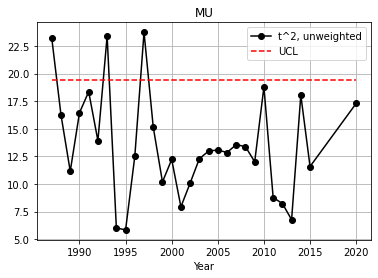

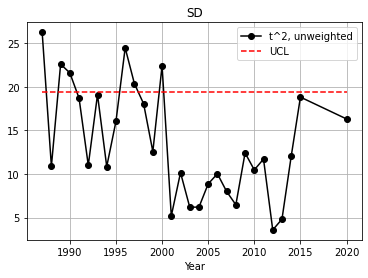

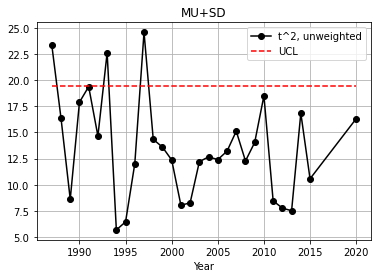

In [13]:
# 95% confidence interval
alpha = 0.95 
# Compute t^2 distributions for mean & standard deviations
mu_t2, ucl = hotelling_t2(mu, alpha)
sd_t2, ucl = hotelling_t2(sd, alpha)
# Define plot paramters
linestyle = ['-ok','--r']
leg = ['t^2, unweighted','UCL']
# Output mean SPC chart
years = mu_df['Year'].values.reshape(-1,1)
t = np.hstack((years, years))
y = np.hstack((mu_t2, np.ones((len(mu_t2),1))*ucl))
time_series_plot(t, y, 'MU', 'Year', '', linestyle, leg)
# Output std SPC chart
y = np.hstack((sd_t2, np.ones((len(sd_t2),1))*ucl))
time_series_plot(t, y, 'SD', 'Year', '', linestyle, leg)
# Output combined SPC chart
comb_t2, ucl = hotelling_t2(mu+sd, alpha)
y = np.hstack((comb_t2, np.ones((len(comb_t2),1))*ucl))
time_series_plot(t, y, 'MU+SD', 'Year', '', linestyle, leg)